# BOA Stock prediction with ARIMA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.0 MB/s 
     |████████████████████████████████| 9.8 MB 76.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas_datareader.data import DataReader
from datetime import datetime

In [ ]:
boa=pd.read_csv('/content/drive/MyDrive/boa1.csv',index_col='date')
boa = boa.Value[::-1]

In [ ]:
boa.isnull().sum()

0

In [ ]:
boa.head()

date
02/01/2020    192.0
03/01/2020    192.0
06/01/2020    192.0
07/01/2020    192.0
08/01/2020    190.0
Name: Value, dtype: float64

In [ ]:
print('Statiqtique récapitulative du prix de cloture pour BANK of AFRICA')
boa.describe().transpose()


Statiqtique récapitulative du prix de cloture pour BANK of AFRICA


count    596.000000
mean     165.996812
std       24.193901
min      121.550000
25%      145.175000
50%      160.925000
75%      187.000000
max      223.000000
Name: Value, dtype: float64

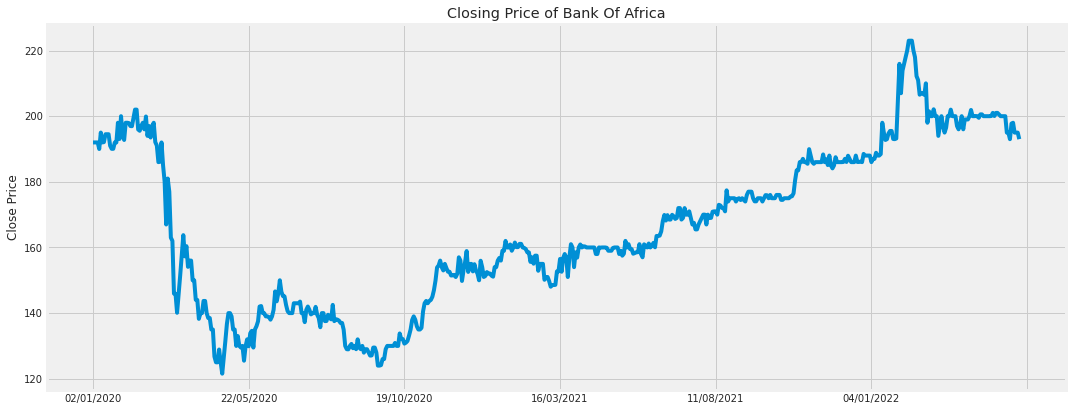

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
# plt.subplot(2, 2)
boa.plot()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Closing Price of Bank Of Africa")
    
plt.tight_layout()

[]

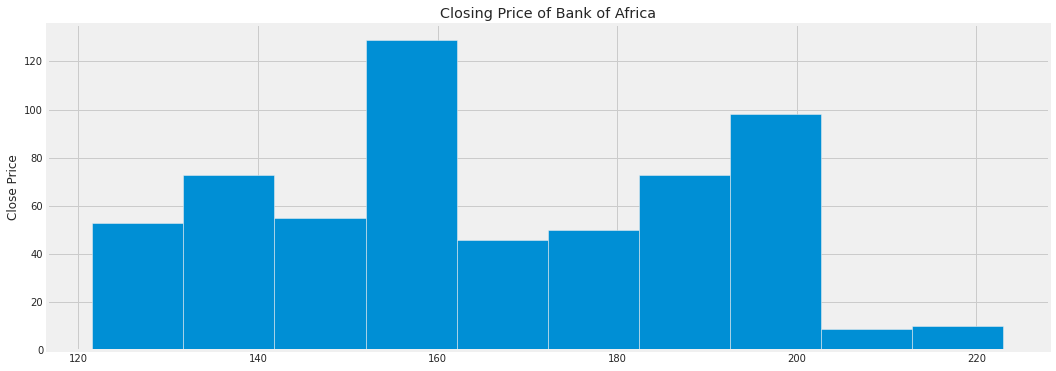

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

boa.hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of Bank of Africa")
    
plt.plot(kind='kde')

La distribution est normale ,on peut alors commencer a faire les tests

[]

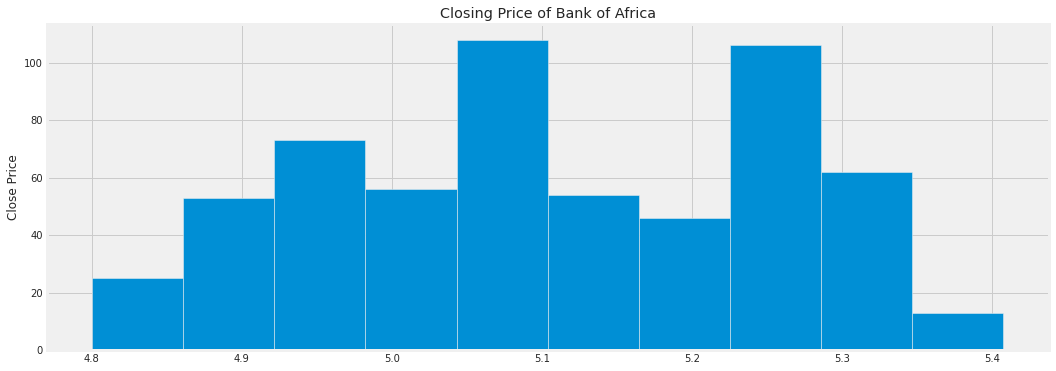

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

np.log(boa).hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of Bank of Africa")
    
plt.plot(kind='kde')

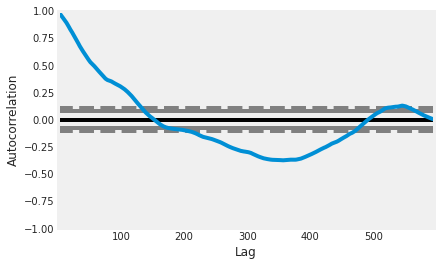

In [ ]:
# autocorrelation of non stationnary data
autocorrelation_plot(boa)
plt.show()

Testing Stationnarity

In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Reject H0. Data has no unit root and is stationary")
    else:
        print("Reject H1 . Data is not stationnary")

In [ ]:
ts = boa.rolling(6).mean().dropna()  #remove trend 

In [ ]:
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.6983821854019414
p-value : 0.431946215810925
#Lags Used : 19
Number of Observations Used : 571
Reject H1 . Data is not stationnary


Le test de dickey fuller nous as montrer que la data est non staationnaire donc maintenant on va essayer de la stationnariser

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.941877547586497
p-value : 9.206398582238384e-15
#Lags Used : 7
Number of Observations Used : 587
Reject H0. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.81684356481936
p-value : 1.8479173023554194e-19
#Lags Used : 16
Number of Observations Used : 577
Reject H0. Data has no unit root and is stationary


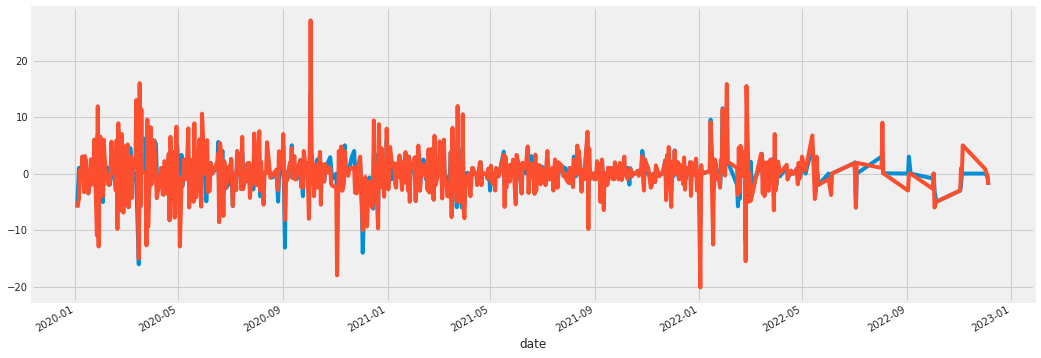

In [ ]:
#  #differencing the series to become stationnary

# def difference(dataset, interval=1):
# 	diff = list()
# 	for i in range(interval, len(dataset)):
# 		value = dataset[i] - dataset[i - interval]
# 		diff.append(value)
    
# 	return numpy.array(diff)
 
# # invert differenced value
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]
#now the date is stationnary
def difference(df,shift_num =1,level = 2):
    
    diff = df- df.shift(1)
    diff.dropna(inplace = True)
    plt.figure(figsize=(16, 6))
    diff.plot()
    diff_level = 1
    re = adf_check(diff)
    
    while diff_level<level:
        diff = diff - diff.shift(shift_num)
        diff.dropna(inplace = True)
        diff.plot()
        re = adf_check(diff)
        diff_level +=1
        
    return re
difference(boa,shift_num=1,level=2)



In [ ]:
#plot the original values first 
original_values = boa

diff_first = boa - boa.shift(1)

Have an idea about the differencing order automatically

In [ ]:
ndiffs(boa,test='adf')

1

According to acf plot we can suppose that the MA q parameter is equal to 1 (q=1)

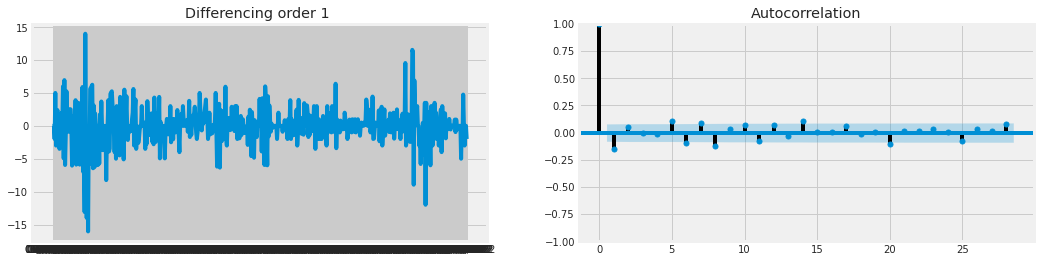

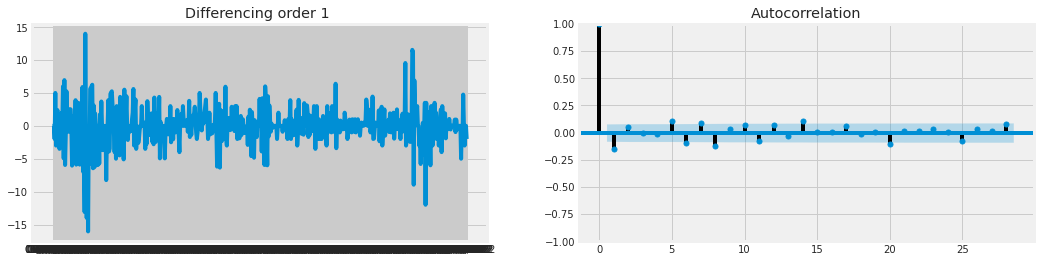

In [ ]:
diff=diff_first.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)
plot_acf(diff,ax=ax2)

According to pacf plot we can suppose that the AR p parameter ,which is the number of the lags , is equal to 1 (q=1)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


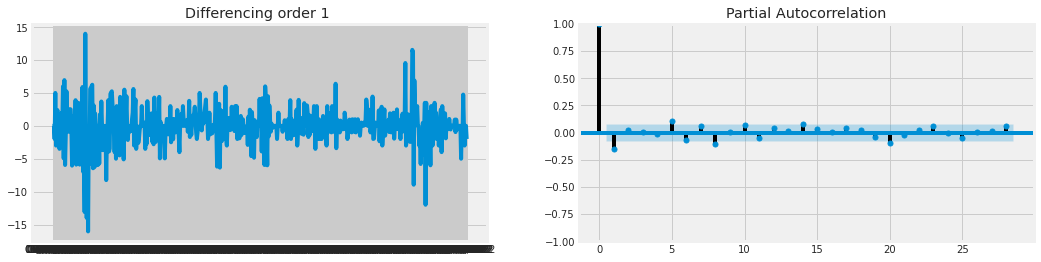

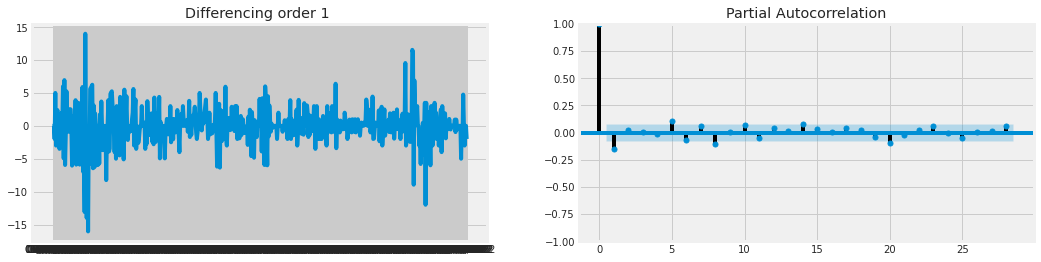

In [ ]:
diff=diff_first.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)

plot_pacf(diff,ax=ax2)

split dataset

In [ ]:
#load the data
data = boa

#divide into train and validation set
train = data[:int(0.7*(len(data)))]
test = data[int(0.7*(len(data))):]


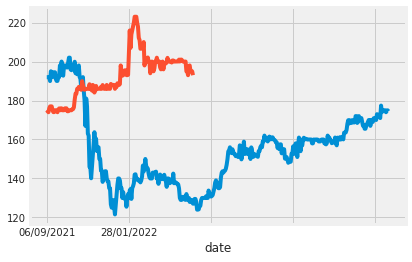

In [ ]:
train.plot()
test.plot()

We will use the autoarima to search for the best combination of q ,d ,p using the AIC , BIC tests

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2067.946, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2059.947, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2060.881, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2066.035, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2061.240, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2061.371, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2063.240, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2058.067, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2059.351, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2059.485, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2059.002, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2061.350, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.960 seconds
                               SARIMAX Results                                
Dep. Vari

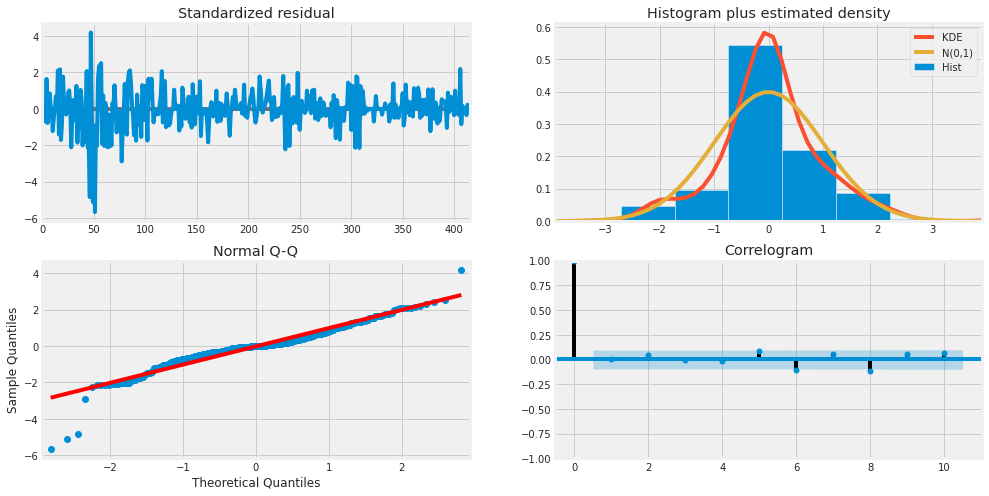

In [ ]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

According to auto arima ,the best model for our boa series is arima(1,1,0)

In [ ]:
# 1,1,2 ARIMA Model
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  417
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1026.743
Date:                Tue, 24 May 2022   AIC                           2059.485
Time:                        01:55:52   BIC                           2071.577
Sample:                             0   HQIC                          2064.267
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3454      0.132     -2.612      0.009      -0.605      -0.086
ma.L1          0.1952      0.140      1.395      0.163      -0.079       0.470
sigma2         8.1526      0.295     27.599      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

In [ ]:
# 1,1,2 ARIMA Model
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  417
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1027.034
Date:                Tue, 24 May 2022   AIC                           2058.067
Time:                        01:57:46   BIC                           2066.129
Sample:                             0   HQIC                          2061.255
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1537      0.032     -4.746      0.000      -0.217      -0.090
sigma2         8.1638      0.295     27.658      0.000       7.585       8.742
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

The model selected by autoarima has the lower AIC BIC values which good, we are noz going to use in our analysis

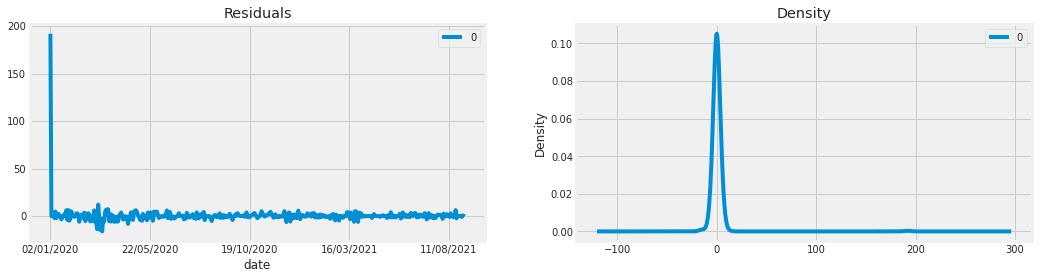

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
residuals.plot(title="Residuals", ax=ax1)
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()


Cette etape concerne lentrainement sur train et levaluation du modele sur test, les resultat entre les valeurs predite par le modele et les valeures relles etaient proches

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


predicted=169.856217, expected=170.000000
predicted=170.000000, expected=167.000000
predicted=167.431225, expected=170.000000
predicted=169.561989, expected=169.000000
predicted=169.146498, expected=169.000000
predicted=169.000000, expected=170.900000
predicted=170.621732, expected=171.000000
predicted=170.985375, expected=171.000000
predicted=171.000000, expected=170.000000
predicted=170.146249, expected=173.000000
predicted=172.558751, expected=172.800000
predicted=172.829375, expected=172.050000
predicted=172.160121, expected=172.000000
predicted=172.007340, expected=171.000000
predicted=171.146781, expected=177.400000
predicted=176.448966, expected=174.000000
predicted=174.520581, expected=175.000000
predicted=174.846419, expected=175.000000
predicted=175.000000, expected=175.000000
predicted=175.000000, expected=175.000000
predicted=175.000000, expected=174.000000
predicted=174.153540, expected=174.800000
predicted=174.677019, expected=175.000000
predicted=174.969269, expected=174

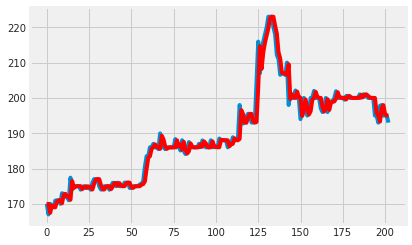

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m-%d')

boa.index=pd.to_datetime(boa.index)
series = boa
series.index = pd.to_datetime(series.index)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
# mape = np.mean(np.abs(test, predictions)/np.abs(test, predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
# # Generate error data
#   #mean squared error
# mse = mean_squared_error(test, predictions)
# print('MSE: '+str(mse))
#   #mean absolute error
# mae = mean_absolute_error(test, predictions)
# print('MAE: '+str(mae))
#   #root mean squared error
# rmse = math.sqrt(mean_squared_error(test, predictions))
# print('RMSE: '+str(rmse))
#   #mean absolute percentage error
#   mse = mean_squared_error(test, predictions)
# mape = np.mean(np.abs(test, predictions)/np.abs(test, predictions))
# print('MAPE: '+str(mape))

In [ ]:
from pandas import read_csv
from statsmodels import *
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
series = train
# seasonal difference
X = series
first = 1
differenced = difference(X, first)
# fit model
# model = statsmodels.tsa.arima.model.ARIMA(differenced, order=(1,1,0))
# model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=20)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 397.000000
Day 2: 390.950000
Day 3: 390.550000
Day 4: 392.000000
Day 5: 393.000000
Day 6: 391.000000
Day 7: 394.900000
Day 8: 389.000000
Day 9: 392.000000
Day 10: 388.500000
Day 11: 392.000000
Day 12: 393.000000
Day 13: 387.100000
Day 14: 386.050000
Day 15: 381.000000
Day 16: 381.100000
Day 17: 387.000000
Day 18: 380.000000
Day 19: 375.100000
Day 20: 362.000000


In [ ]:
# def forecast(ARIMA_model, periods=24):
#     # Forecast
#     n_periods = periods
#     fitted = model_fit.predict(steps=periods)
#     index_of_fc = pd.date_range(pd.to_datetime(boa.index), periods = n_periods, freq='MS')

#     # make series for plotting purpose
#     fitted_series = pd.Series(fitted)
#     # lower_series = pd.Series(fitted_series[1][:, 0], index=index_of_fc)
#     # upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#     # Plot
#     plt.figure(figsize=(15,7))
#     plt.plot(boa, color='#1f76b4')
#     plt.plot(fitted_series, color='darkgreen')
#     plt.fill_between(lower_series.index, 
#                     lower_series, 
#                     upper_series, 
#                     color='k', alpha=.15)

#     plt.title("ARIMA - Forecast of Airline Passengers")
#     plt.show()

# forecast(model)

TypeError: ignored

i ll be doing the same for MANAGEM ,Sonasid et total

# Managem

In [ ]:
mng=pd.read_csv('/content/drive/MyDrive/mng1.csv',index_col='date')
mng = mng.Value[::-1]

In [ ]:
mng.isnull().sum()

0

In [ ]:
mng.head()


date
02/01/2020    850.0
03/01/2020    805.0
06/01/2020    805.0
07/01/2020    810.0
08/01/2020    832.0
Name: Value, dtype: float64

In [ ]:

print('Statiqtique récapitulative du prix de cloture pour Managem')
mng.describe().transpose()

Statiqtique récapitulative du prix de cloture pour Managem


count     596.000000
mean     1269.855453
std       451.449532
min       396.400000
25%       899.875000
50%      1344.000000
75%      1560.000000
max      2297.000000
Name: Value, dtype: float64

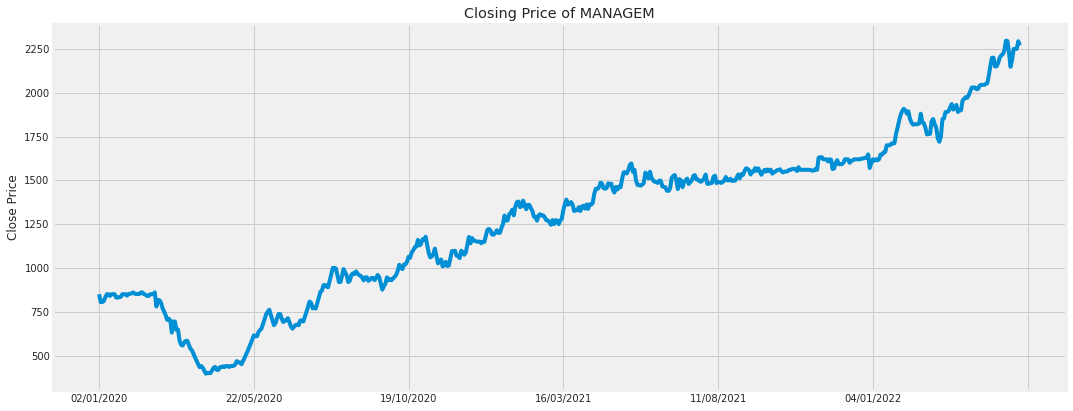

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
# plt.subplot(2, 2)
mng.plot()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Closing Price of MANAGEM")
    
plt.tight_layout()

[]

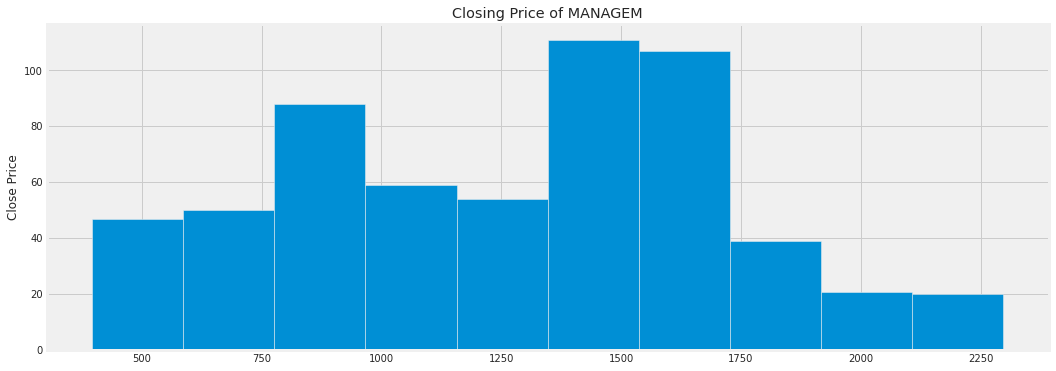

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

mng.hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of MANAGEM")
    
plt.plot(kind='kde')

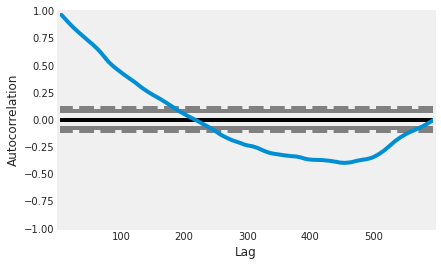

In [ ]:
# autocorrelation of non stationnary data
autocorrelation_plot(mng)
plt.show()

In [ ]:
ts = mng.rolling(6).mean().dropna()  #remove trend 
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.4357910795131744
p-value : 0.9827851710390406
#Lags Used : 19
Number of Observations Used : 571
Reject H1 . Data is not stationnary


Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.48521796391415
p-value : 1.35907861551809e-13
#Lags Used : 6
Number of Observations Used : 588
Reject H0. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.036253371809936
p-value : 5.50777770959848e-20
#Lags Used : 13
Number of Observations Used : 580
Reject H0. Data has no unit root and is stationary


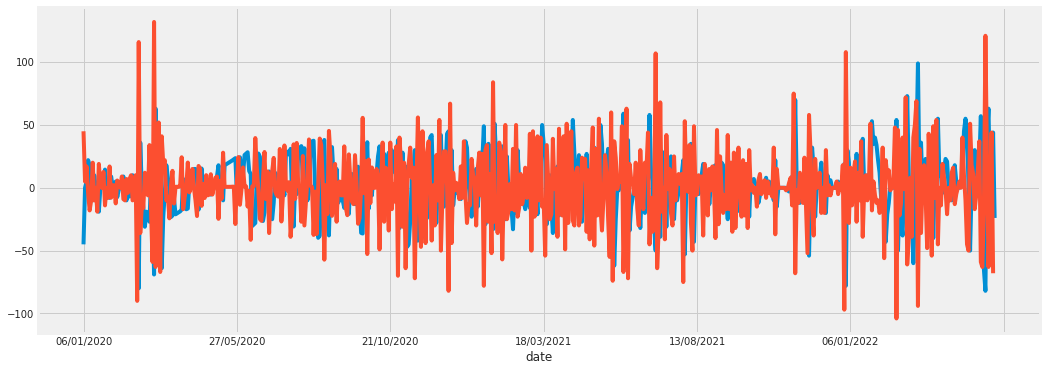

In [ ]:
difference(mng,shift_num=1,level=2)

In [ ]:
#plot the original values first 
original_values = mng

diff_first2 = mng - mng.shift(1)
ndiffs(mng,test='adf')

1

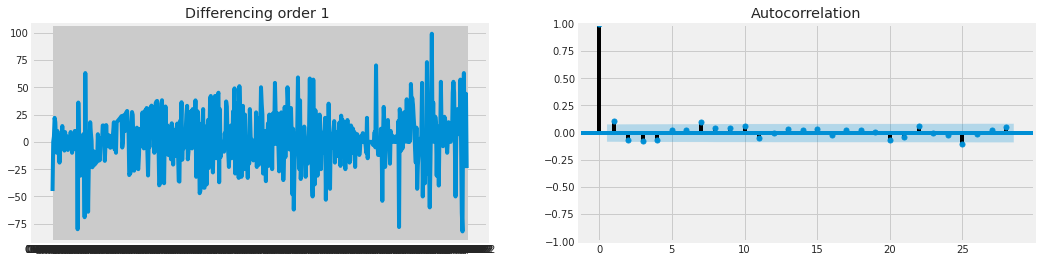

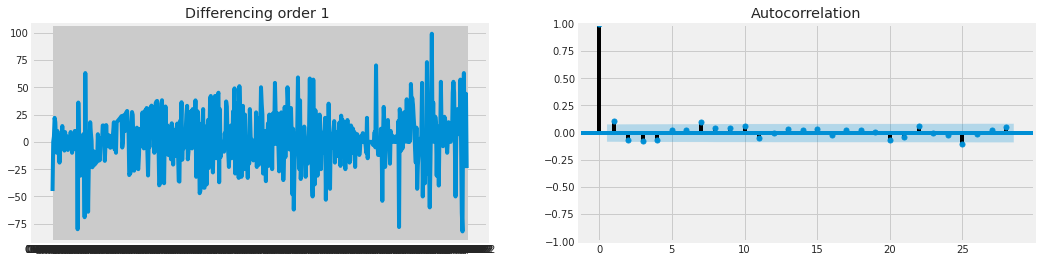

In [ ]:
diff=diff_first2.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)
plot_acf(diff,ax=ax2)


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


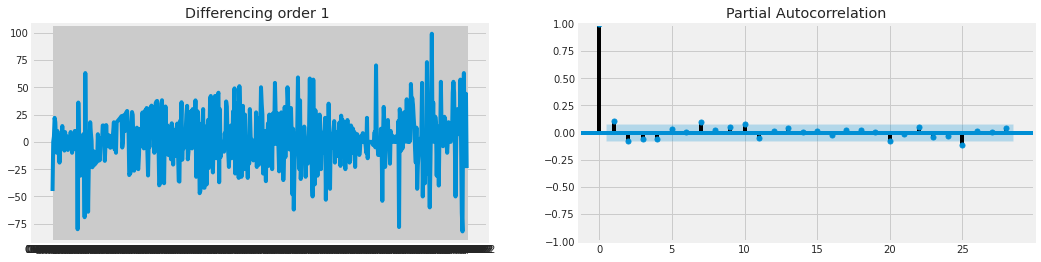

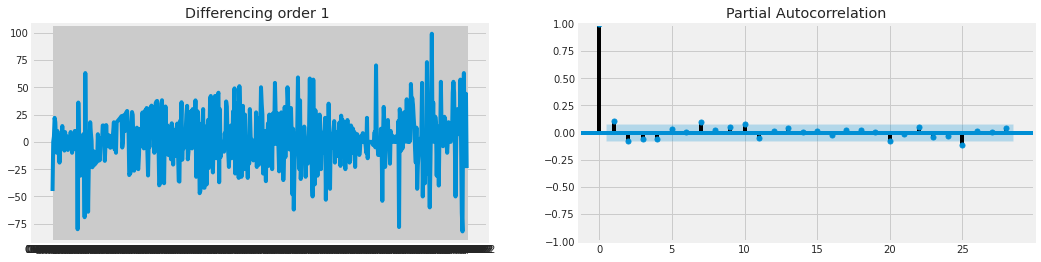

In [ ]:

diff=diff_first2.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)

plot_pacf(diff,ax=ax2)

In [ ]:
#load the data
data = mng

#divide into train and validation set
train2 = data[:int(0.7*(len(data)))]
test2 = data[int(0.7*(len(data))):]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2818.225, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2807.794, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2809.615, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2822.151, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2807.193, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2808.962, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2809.106, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2807.430, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2810.501, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2808.724, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.073 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  417
Model:               SARIMAX(2, 1, 0)   Log Likelihood        

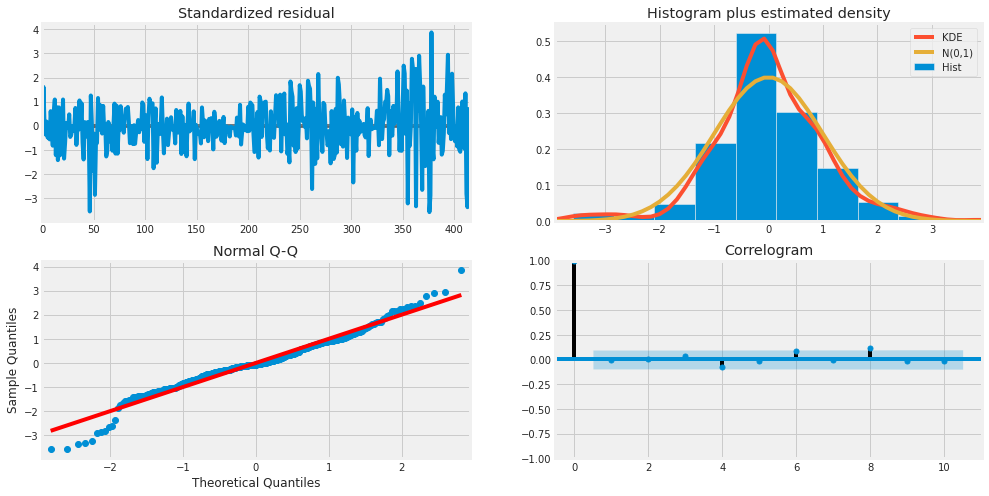

In [ ]:

from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train2, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model2 = ARIMA(train2, order=(2,1,0))
model_fit = model2.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  417
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1401.362
Date:                Tue, 24 May 2022   AIC                           2808.724
Time:                        03:39:12   BIC                           2820.816
Sample:                             0   HQIC                          2813.505
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1669      0.033      5.023      0.000       0.102       0.232
ar.L2          0.0879      0.037      2.349      0.019       0.015       0.161
sigma2        49.3690      2.497     19.775      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

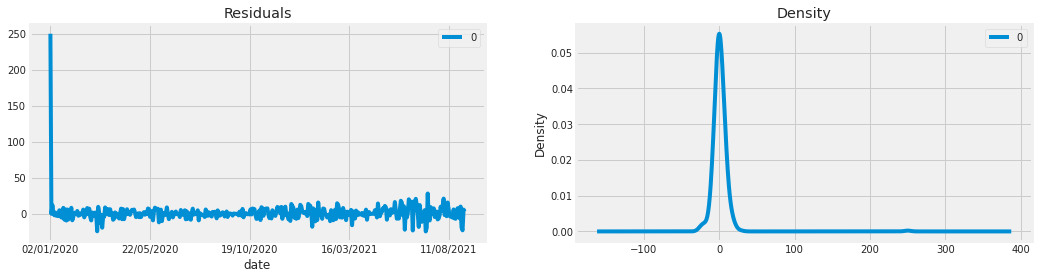

In [ ]:

residuals = pd.DataFrame(model_fit.resid)
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
residuals.plot(title="Residuals", ax=ax1)
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

predicted=1534.980801, expected=1480.000000
predicted=1473.046130, expected=1480.000000
predicted=1482.748554, expected=1484.000000
predicted=1484.429332, expected=1485.000000
predicted=1484.898551, expected=1520.000000
predicted=1523.709282, expected=1527.000000
predicted=1525.952265, expected=1484.000000
predicted=1478.973784, expected=1490.000000
predicted=1493.132863, expected=1490.000000
predicted=1489.654794, expected=1485.000000
predicted=1484.476353, expected=1490.000000
predicted=1490.811262, expected=1500.000000
predicted=1500.758887, expected=1519.000000
predicted=1520.433215, expected=1500.000000
predicted=1496.917244, expected=1500.000000
predicted=1501.103087, expected=1509.000000
predicted=1509.932607, expected=1496.000000
predicted=1494.132352, expected=1498.000000
predicted=1498.966577, expected=1498.000000
predicted=1497.883032, expected=1515.000000
predicted=1516.745817, expected=1533.000000
predicted=1533.879810, expected=1511.000000
predicted=1507.667960, expected=

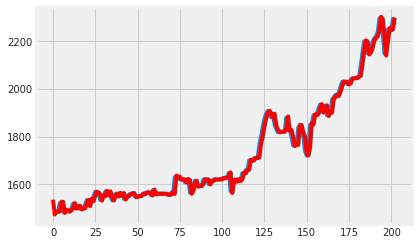

In [ ]:
# from pandas import read_csv
# from pandas import datetime
# from matplotlib import pyplot
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m-%d')

mng.index=pd.to_datetime(mng.index)
series = mng
series.index = pd.to_datetime(series.index)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
# mape = np.mean(np.abs(test, predictions)/np.abs(test, predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
from pandas import read_csv
from statsmodels import *
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
series = train2
# seasonal difference
X = series
first = 1
differenced = difference(X, first)
# fit model
# model = statsmodels.tsa.arima.model.ARIMA(differenced, order=(1,1,0))
# model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=20)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 2488.762325
Day 2: 2478.942490
Day 3: 2471.006846
Day 4: 2478.023183
Day 5: 2478.078722
Day 6: 2485.281392
Day 7: 2492.677938
Day 8: 2492.777307
Day 9: 2499.777461
Day 10: 2500.327524
Day 11: 2501.877522
Day 12: 2493.877517
Day 13: 2486.027517
Day 14: 2485.877517
Day 15: 2485.877517
Day 16: 2481.877517
Day 17: 2479.877517
Day 18: 2472.627517
Day 19: 2472.027517
Day 20: 2478.427517


# Sonasid

In [ ]:
snd=pd.read_csv('/content/drive/MyDrive/snd1.csv',index_col='date')
snd = snd.Value[::-1]

In [ ]:
snd.isnull().sum()

0

In [ ]:
snd.head()


date
02/01/2020    250.0
03/01/2020    250.0
06/01/2020    262.0
07/01/2020    265.0
08/01/2020    264.5
Name: Value, dtype: float64

In [ ]:

print('Statiqtique récapitulative du prix de cloture pour SONASID')
snd.describe().transpose()

Statiqtique récapitulative du prix de cloture pour SONASID


count    596.000000
mean     425.187164
std      207.405411
min      171.950000
25%      221.575000
50%      370.050000
75%      610.000000
max      884.000000
Name: Value, dtype: float64

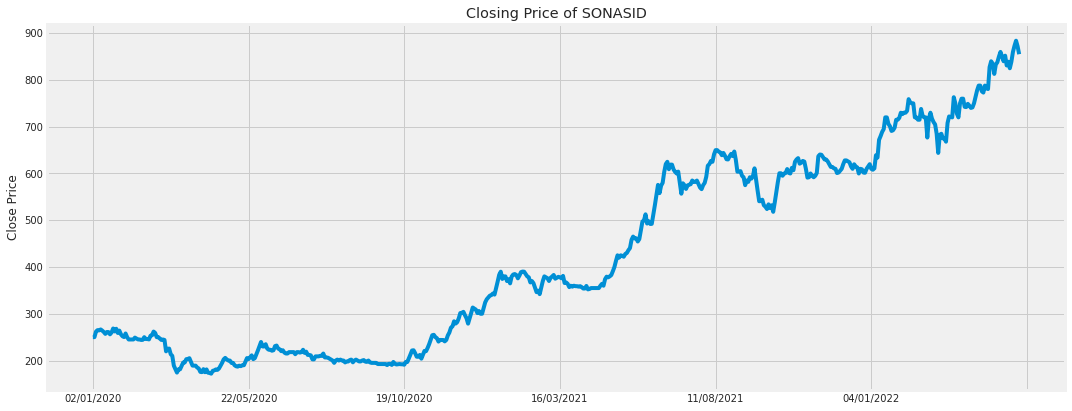

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
# plt.subplot(2, 2)
snd.plot()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Closing Price of SONASID")
    
plt.tight_layout()

[]

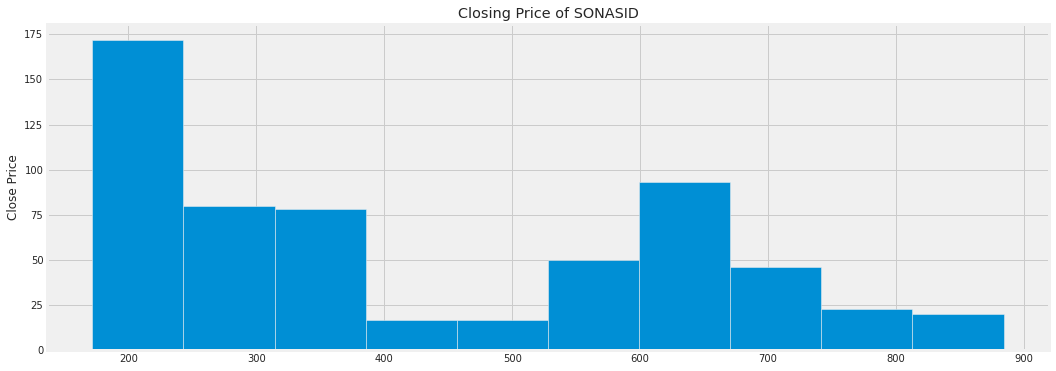

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

snd.hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of SONASID")
    
plt.plot(kind='kde')

[]

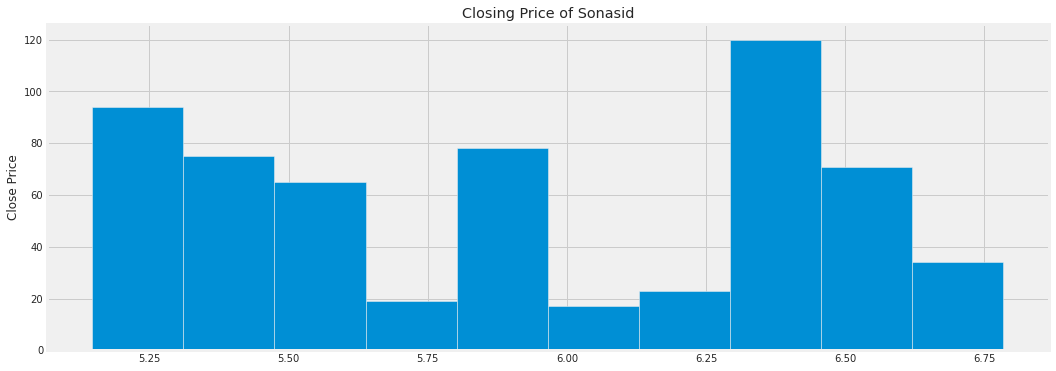

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

np.log(snd).hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of Sonasid")
    
plt.plot(kind='kde')

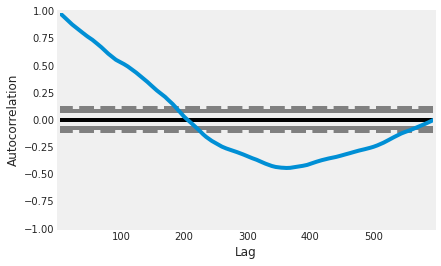

In [ ]:
# autocorrelation of non stationnary data
autocorrelation_plot(snd)
plt.show()

In [ ]:
ts = snd.rolling(6).mean().dropna()  #remove trend 
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.6304940066574474
p-value : 0.988343627440492
#Lags Used : 19
Number of Observations Used : 571
Reject H1 . Data is not stationnary


Augmented Dickey-Fuller Test:
ADF Test Statistic : -22.399885809075414
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 594
Reject H0. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.974801027206095
p-value : 3.82393165368756e-22
#Lags Used : 14
Number of Observations Used : 579
Reject H0. Data has no unit root and is stationary


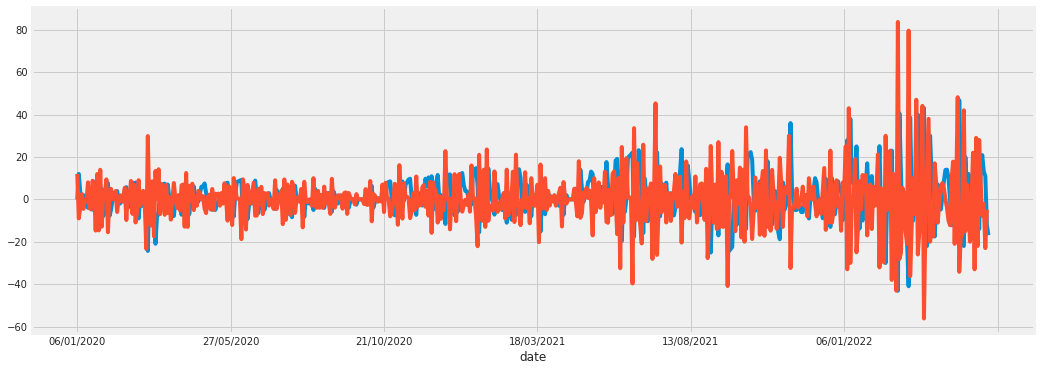

In [ ]:
difference(snd,shift_num=1,level=2)


In [ ]:
#plot the original values first 
original_values = snd

diff_first3 = snd - snd.shift(1)
ndiffs(snd,test='adf')

1

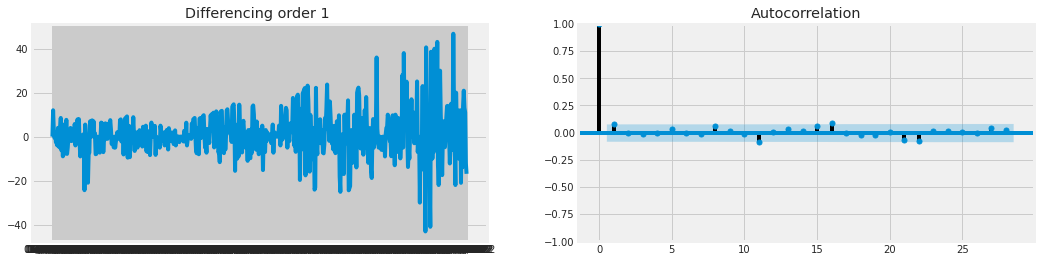

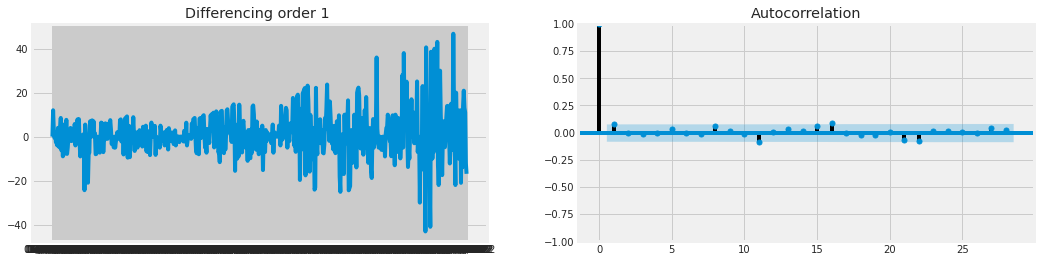

In [ ]:
diff=diff_first3.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)
plot_acf(diff,ax=ax2)


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


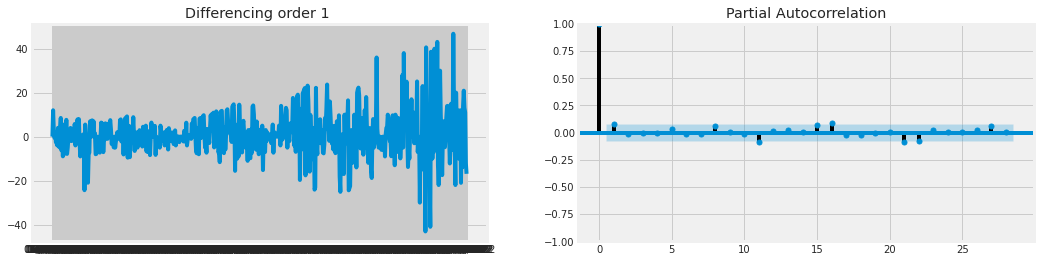

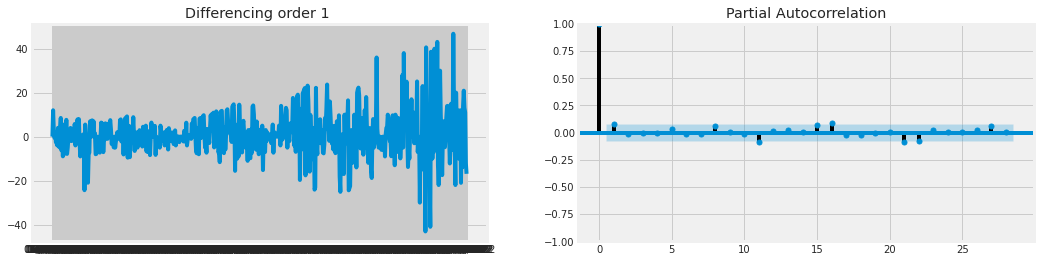

In [ ]:

diff=diff_first3.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)

plot_pacf(diff,ax=ax2)

In [ ]:
#load the data
data = snd

#divide into train and validation set
train3 = data[:int(0.7*(len(data)))]
test3 = data[int(0.7*(len(data))):]

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2818.225, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2807.794, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2809.615, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2822.151, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2807.193, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2808.962, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2809.106, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2807.430, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2810.501, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2808.724, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.355 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  417
Model:               SARIMAX(2, 1, 0)   Log Likelihood        

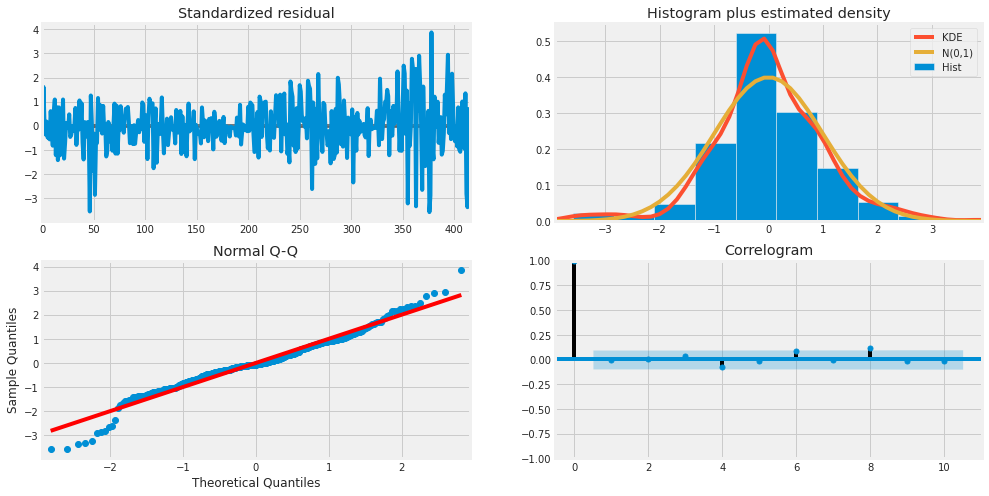

In [ ]:

from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train3, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  417
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1401.362
Date:                Tue, 24 May 2022   AIC                           2808.724
Time:                        03:37:51   BIC                           2820.816
Sample:                             0   HQIC                          2813.505
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1669      0.033      5.023      0.000       0.102       0.232
ar.L2          0.0879      0.037      2.349      0.019       0.015       0.161
sigma2        49.3690      2.497     19.775      0.0

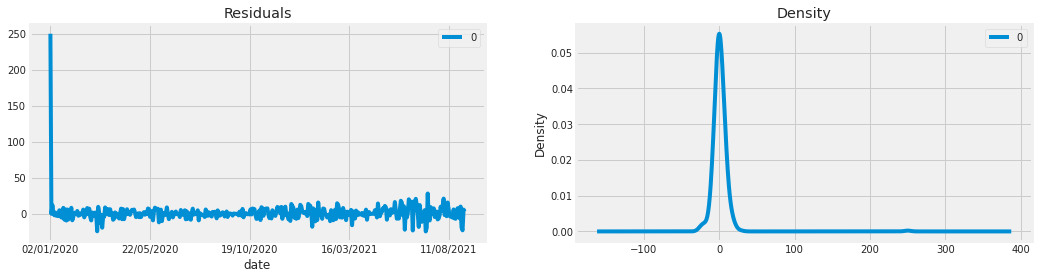

In [ ]:

model3 = ARIMA(train3, order=(2,1,0))
model_fit = model3.fit()
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
residuals.plot(title="Residuals", ax=ax1)
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

predicted=575.905040, expected=580.000000
predicted=581.552894, expected=593.000000
predicted=595.457445, expected=616.700000
predicted=621.939552, expected=620.000000
predicted=622.966795, expected=626.900000
predicted=628.371634, expected=625.000000
predicted=625.432904, expected=641.000000
predicted=643.317462, expected=650.000000
predicted=653.255111, expected=650.000000
predicted=650.979674, expected=646.800000
predicted=646.277708, expected=645.000000
predicted=644.363828, expected=639.100000
predicted=637.940076, expected=644.000000
predicted=644.160078, expected=638.000000
predicted=637.576108, expected=630.500000
predicted=628.635812, expected=630.000000
predicted=629.115740, expected=637.000000
predicted=638.085711, expected=642.000000
predicted=643.545965, expected=637.300000
predicted=637.044015, expected=647.000000
predicted=648.058970, expected=629.000000
predicted=627.380091, expected=603.900000
predicted=597.840949, expected=604.000000
predicted=601.710299, expected=605

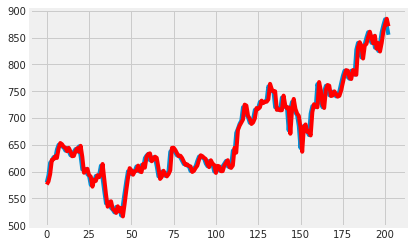

In [ ]:
 
# from pandas import datetime
# from matplotlib import pyplot
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m-%d')

snd.index=pd.to_datetime(snd.index)
series = snd
series.index = pd.to_datetime(series.index)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
# mape = np.mean(np.abs(test, predictions)/np.abs(test, predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
from pandas import read_csv
from statsmodels import *
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
series = train3
# seasonal difference
X = series
first = 1
differenced = difference(X, first)
# fit model
# model = statsmodels.tsa.arima.model.ARIMA(differenced, order=(1,1,0))
# model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=20)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 1060.014396
Day 2: 1052.373449
Day 3: 1045.115464
Day 4: 1052.064763
Day 5: 1052.064701
Day 6: 1059.264696
Day 7: 1066.664695
Day 8: 1066.764695
Day 9: 1073.764695
Day 10: 1074.314695
Day 11: 1075.864695
Day 12: 1067.864695
Day 13: 1060.014695
Day 14: 1059.864695
Day 15: 1059.864695
Day 16: 1055.864695
Day 17: 1053.864695
Day 18: 1046.614695
Day 19: 1046.014695
Day 20: 1052.414695


# TOTAL

In [ ]:
ttl=pd.read_csv('/content/drive/MyDrive/ttl1.csv',index_col='date')
ttl = ttl.Value[::-1]

In [ ]:
ttl.isnull().sum()

0

In [ ]:
ttl = ttl.fillna(ttl.mean())

In [ ]:
ttl.head()


date
02/01/2020    1315.756303
03/01/2020    1171.000000
06/01/2020    1171.000000
07/01/2020    1171.000000
08/01/2020    1248.000000
Name: Value, dtype: float64

In [ ]:
print('Statiqtique récapitulative du prix de cloture pour TOTAL')
ttl.describe().transpose()

Statiqtique récapitulative du prix de cloture pour TOTAL


count     596.000000
mean     1315.756303
std       332.495234
min       790.000000
25%       944.500000
50%      1290.000000
75%      1652.500000
max      1850.000000
Name: Value, dtype: float64

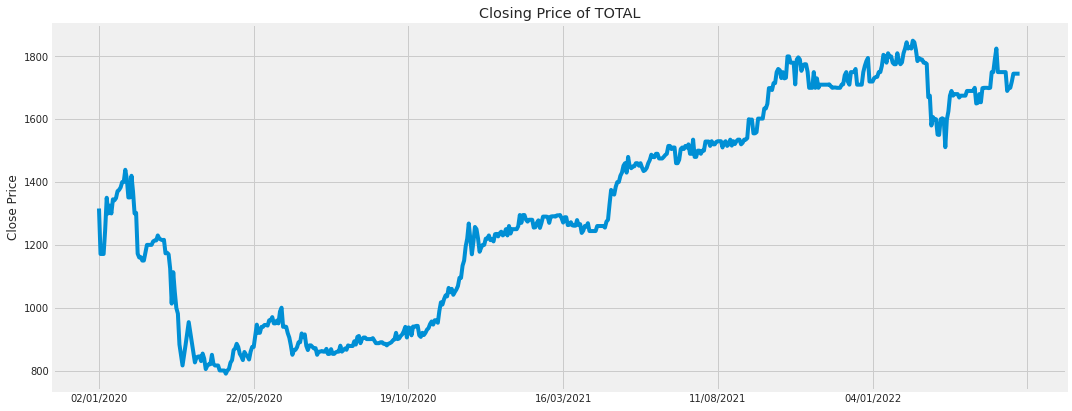

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)
# plt.subplot(2, 2)
ttl.plot()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Closing Price of TOTAL")
    
plt.tight_layout()

[]

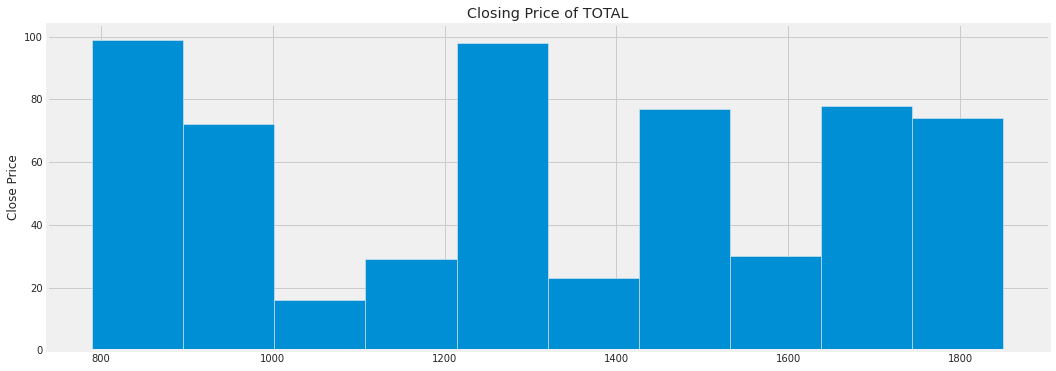

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

ttl.hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of TOTAL")
    
plt.plot(kind='kde')

[]

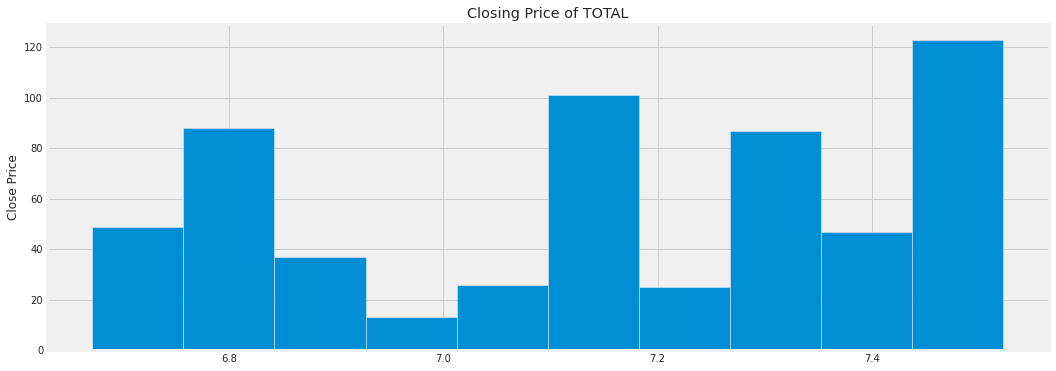

In [ ]:
plt.figure(figsize=(16, 6))
# plt.subplots_adjust()

np.log(ttl).hist()
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title(f"Closing Price of TOTAL")
    
plt.plot(kind='kde')

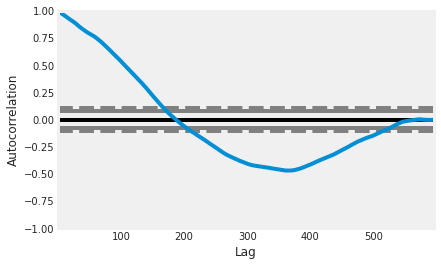

In [ ]:
# autocorrelation of non stationnary data
autocorrelation_plot(ttl)
plt.show()

In [ ]:
ts = ttl.rolling(6).mean().dropna()  #remove trend 
adf_check(ts)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.5809433529205468
p-value : 0.8752301696168252
#Lags Used : 19
Number of Observations Used : 571
Reject H1 . Data is not stationnary


Augmented Dickey-Fuller Test:
ADF Test Statistic : -26.783580374892484
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 594
Reject H0. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.326367817571256
p-value : 2.9186898311373325e-18
#Lags Used : 13
Number of Observations Used : 580
Reject H0. Data has no unit root and is stationary


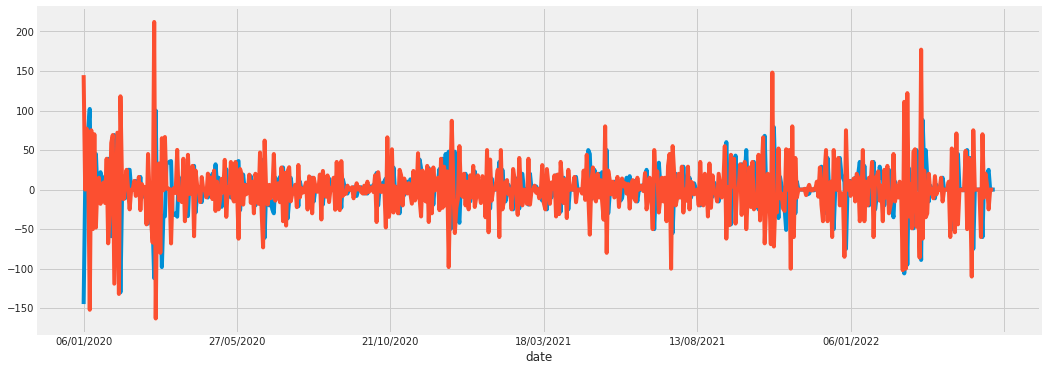

In [ ]:
difference(ttl,shift_num=1,level=2)

In [ ]:
#plot the original values first 
original_values = ttl

diff_first4 = ttl - ttl.shift(1)
ndiffs(ttl,test='adf')

1

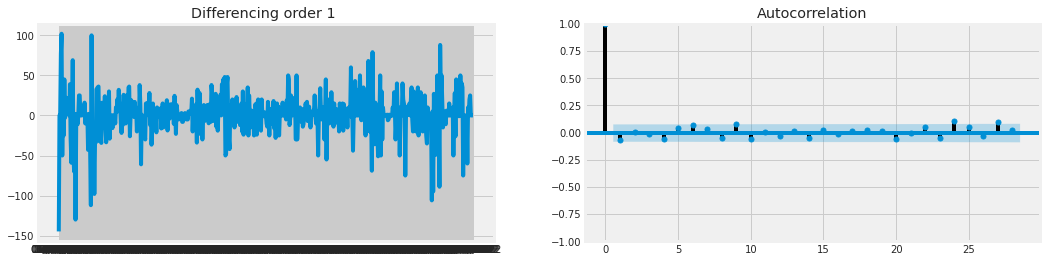

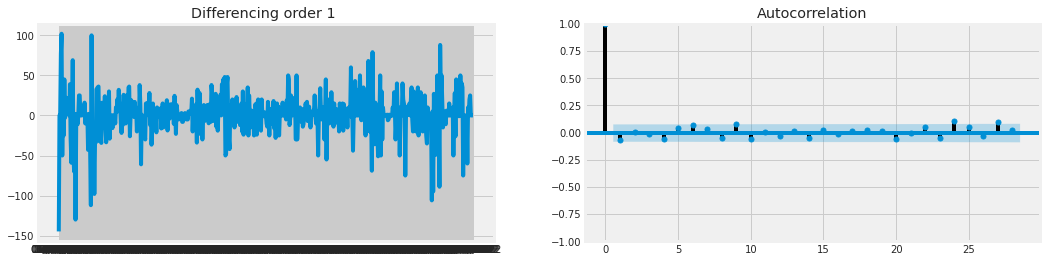

In [ ]:
diff=diff_first4.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)
plot_acf(diff,ax=ax2)


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


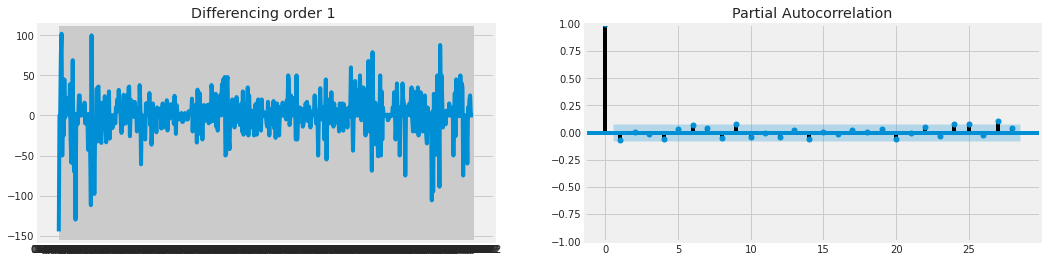

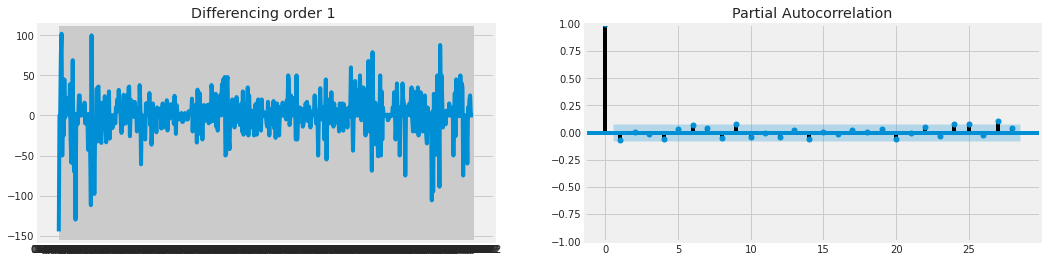

In [ ]:
diff=diff_first4.dropna()
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title('Differencing order 1 ')
# ax2.plot_acf(diff,ax=ax2)

plot_pacf(diff,ax=ax2)

In [ ]:
#load the data
data = ttl

#divide into train and validation set
train4 = data[:int(0.7*(len(data)))]
test4 = data[int(0.7*(len(data))):]


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3821.068, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3822.843, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3822.841, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3819.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3821.723, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.567 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  417
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1908.627
Date:                Tue, 24 May 2022   AIC                           3819.255
Time:                        03:37:07   BIC                           3823.285
Sample:                             0   HQIC                          3820.848
                                - 417                                       

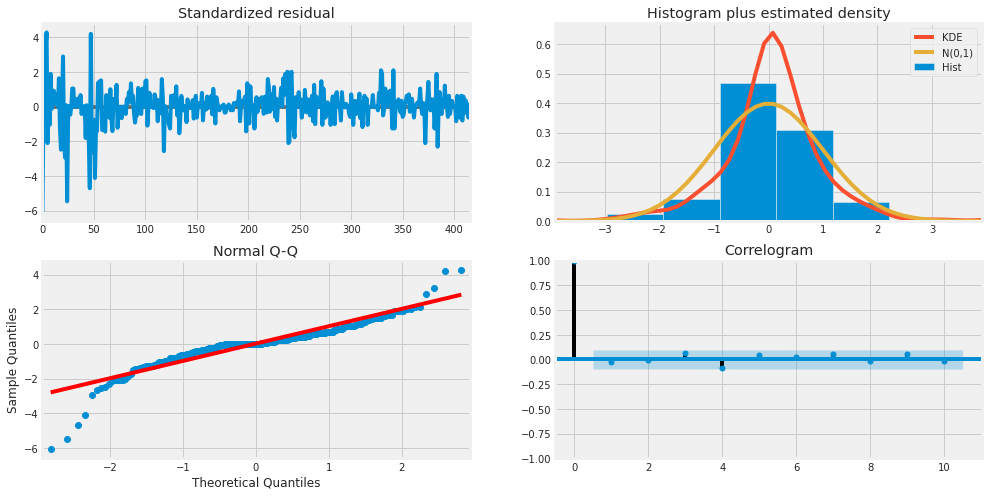

In [ ]:


model_autoARIMA = auto_arima(train4, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  417
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1908.627
Date:                Tue, 24 May 2022   AIC                           3819.255
Time:                        03:37:11   BIC                           3823.285
Sample:                             0   HQIC                          3820.848
                                - 417                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       565.7901     17.534     32.267      0.000     531.423     600.157
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):              1220.32
Prob(Q):                              0.66   Pr

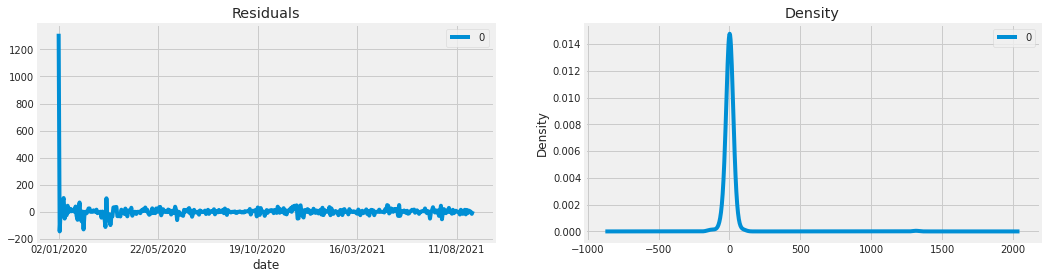

In [ ]:

model4 = ARIMA(train4, order=(0,1,0))
model_fit = model4.fit()
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
fig, ( ax1 , ax2)= plt.subplots(1,2, figsize=(16,4))
residuals.plot(title="Residuals", ax=ax1)
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

predicted=1529.000000, expected=1529.000000
predicted=1529.000000, expected=1529.000000
predicted=1529.000000, expected=1515.000000
predicted=1515.000000, expected=1530.000000
predicted=1530.000000, expected=1520.000000
predicted=1520.000000, expected=1520.000000
predicted=1520.000000, expected=1528.000000
predicted=1528.000000, expected=1530.000000
predicted=1530.000000, expected=1530.000000
predicted=1530.000000, expected=1530.000000
predicted=1530.000000, expected=1510.000000
predicted=1510.000000, expected=1525.000000
predicted=1525.000000, expected=1530.000000
predicted=1530.000000, expected=1515.000000
predicted=1515.000000, expected=1520.000000
predicted=1520.000000, expected=1535.000000
predicted=1535.000000, expected=1516.000000
predicted=1516.000000, expected=1530.000000
predicted=1530.000000, expected=1521.000000
predicted=1521.000000, expected=1530.000000
predicted=1530.000000, expected=1535.000000
predicted=1535.000000, expected=1535.000000
predicted=1535.000000, expected=

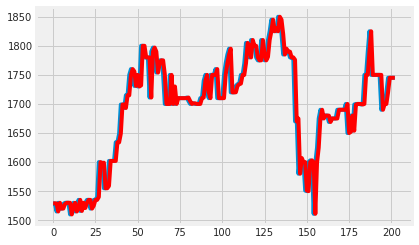

In [ ]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m-%d')

ttl.index=pd.to_datetime(ttl.index)
series = ttl
series.index = pd.to_datetime(series.index)
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
# mape = np.mean(np.abs(test, predictions)/np.abs(test, predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
from pandas import read_csv
from statsmodels import *
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load dataset
series = train4
# seasonal difference
X = series
first = 1
differenced = difference(X, first)
# fit model
# model = statsmodels.tsa.arima.model.ARIMA(differenced, order=(1,1,0))
# model_fit = model.fit()
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=20)
# invert the differenced forecast to something usable
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 2628.000000
Day 2: 2595.000000
Day 3: 2561.100000
Day 4: 2593.700000
Day 5: 2627.600000
Day 6: 2662.900000
Day 7: 2699.000000
Day 8: 2667.000000
Day 9: 2635.000000
Day 10: 2605.000000
Day 11: 2570.700000
Day 12: 2586.600000
Day 13: 2589.200000
Day 14: 2590.000000
Day 15: 2575.000000
Day 16: 2599.000000
Day 17: 2583.000000
Day 18: 2549.500000
Day 19: 2560.000000
Day 20: 2565.000000
